# Some integration tests for batch features

In [1]:
%matplotlib inline
import time

import h5py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import erf
from types import SimpleNamespace
from tqdm.notebook import tqdm

from sklearn import metrics

from bioslds.regressors import BioWTARegressor
from bioslds.plotting import FigureManager, show_latent
from bioslds.cluster_quality import calculate_sliding_score, unordered_accuracy_score
from bioslds.dataset import RandomArmaDataset
from bioslds.batch import hyper_score_ar
from bioslds.arma import make_random_arma
from bioslds.regressor_utils import to_hankel
from bioslds.hdf import write_object_hierarchy, read_namespace_hierarchy

## Test `hyper_score_ar`

### Run on a randomly generated dataset of two ARs

In [2]:
two_armas = SimpleNamespace(
    n_signals=15,
    n_samples=250_000,
    metric=unordered_accuracy_score,
    orders=[(3, 0), (3, 0)],
    dwell_times=50,
    min_dwell=25,
    n_models=2,
    n_features=3,
    rate=1e-3,
    fix_scale=1.0,
)
two_armas.dataset = RandomArmaDataset(
    two_armas.n_signals,
    two_armas.n_samples,
    two_armas.orders,
    dwell_times=two_armas.dwell_times,
    min_dwell=two_armas.min_dwell,
    fix_scale=two_armas.fix_scale,
    arma_kws={"max_pole_radius": 0.9},
)

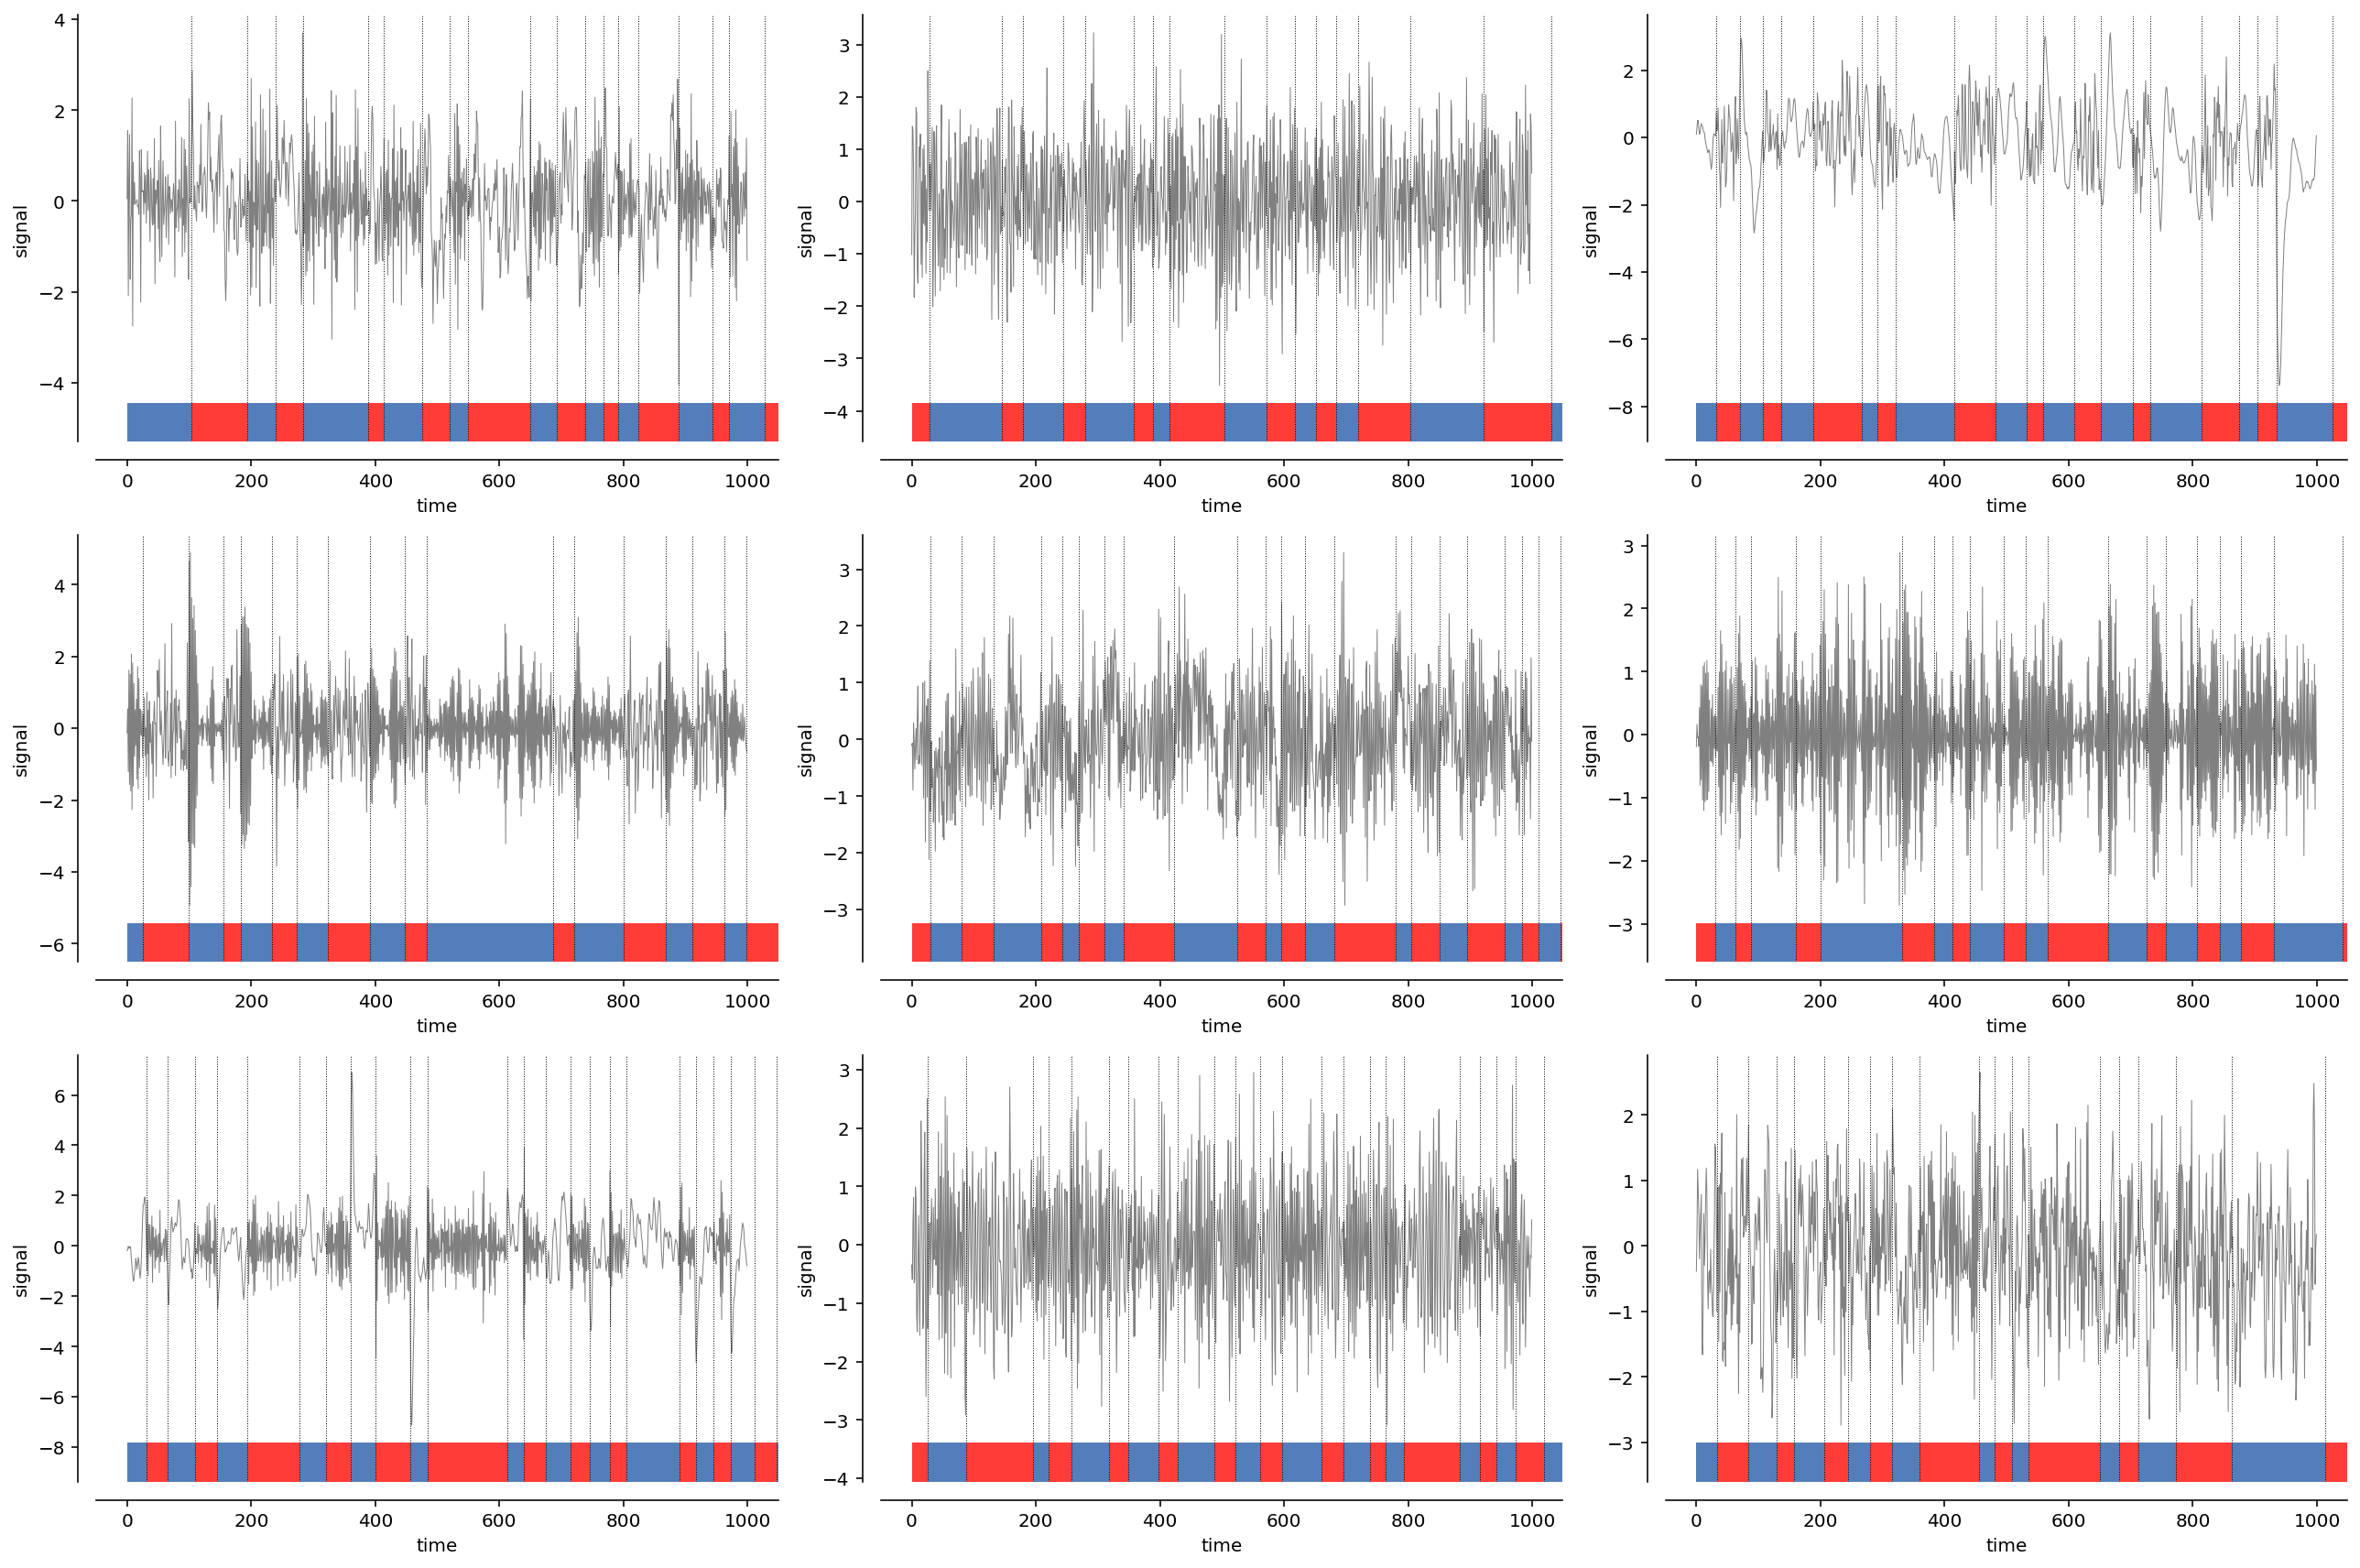

In [3]:
with FigureManager(3, 3) as (_, axs):
    for i, ax in enumerate(axs.flat):
        crt_dataset = two_armas.dataset[i]
        crt_range = slice(0, 1000)
        ax.plot(
            np.arange(len(crt_dataset.y))[crt_range],
            crt_dataset.y[crt_range],
            lw=0.5,
            c="gray",
        )
        show_latent(crt_dataset.usage_seq, bar_location="bottom", ax=ax)

        ax.set_xlabel("time")
        ax.set_ylabel("signal")

ARMA 0.0 std = 1.06
ARMA 0.1 std = 1.03
ARMA 1.0 std = 0.99
ARMA 1.1 std = 1.01
ARMA 2.0 std = 1.52
ARMA 2.1 std = 1.00
ARMA 3.0 std = 1.26
ARMA 3.1 std = 1.02
ARMA 4.0 std = 1.00
ARMA 4.1 std = 1.02
ARMA 5.0 std = 0.99
ARMA 5.1 std = 1.04
ARMA 6.0 std = 1.40
ARMA 6.1 std = 1.07
ARMA 7.0 std = 1.01
ARMA 7.1 std = 1.02
ARMA 8.0 std = 1.00
ARMA 8.1 std = 0.99


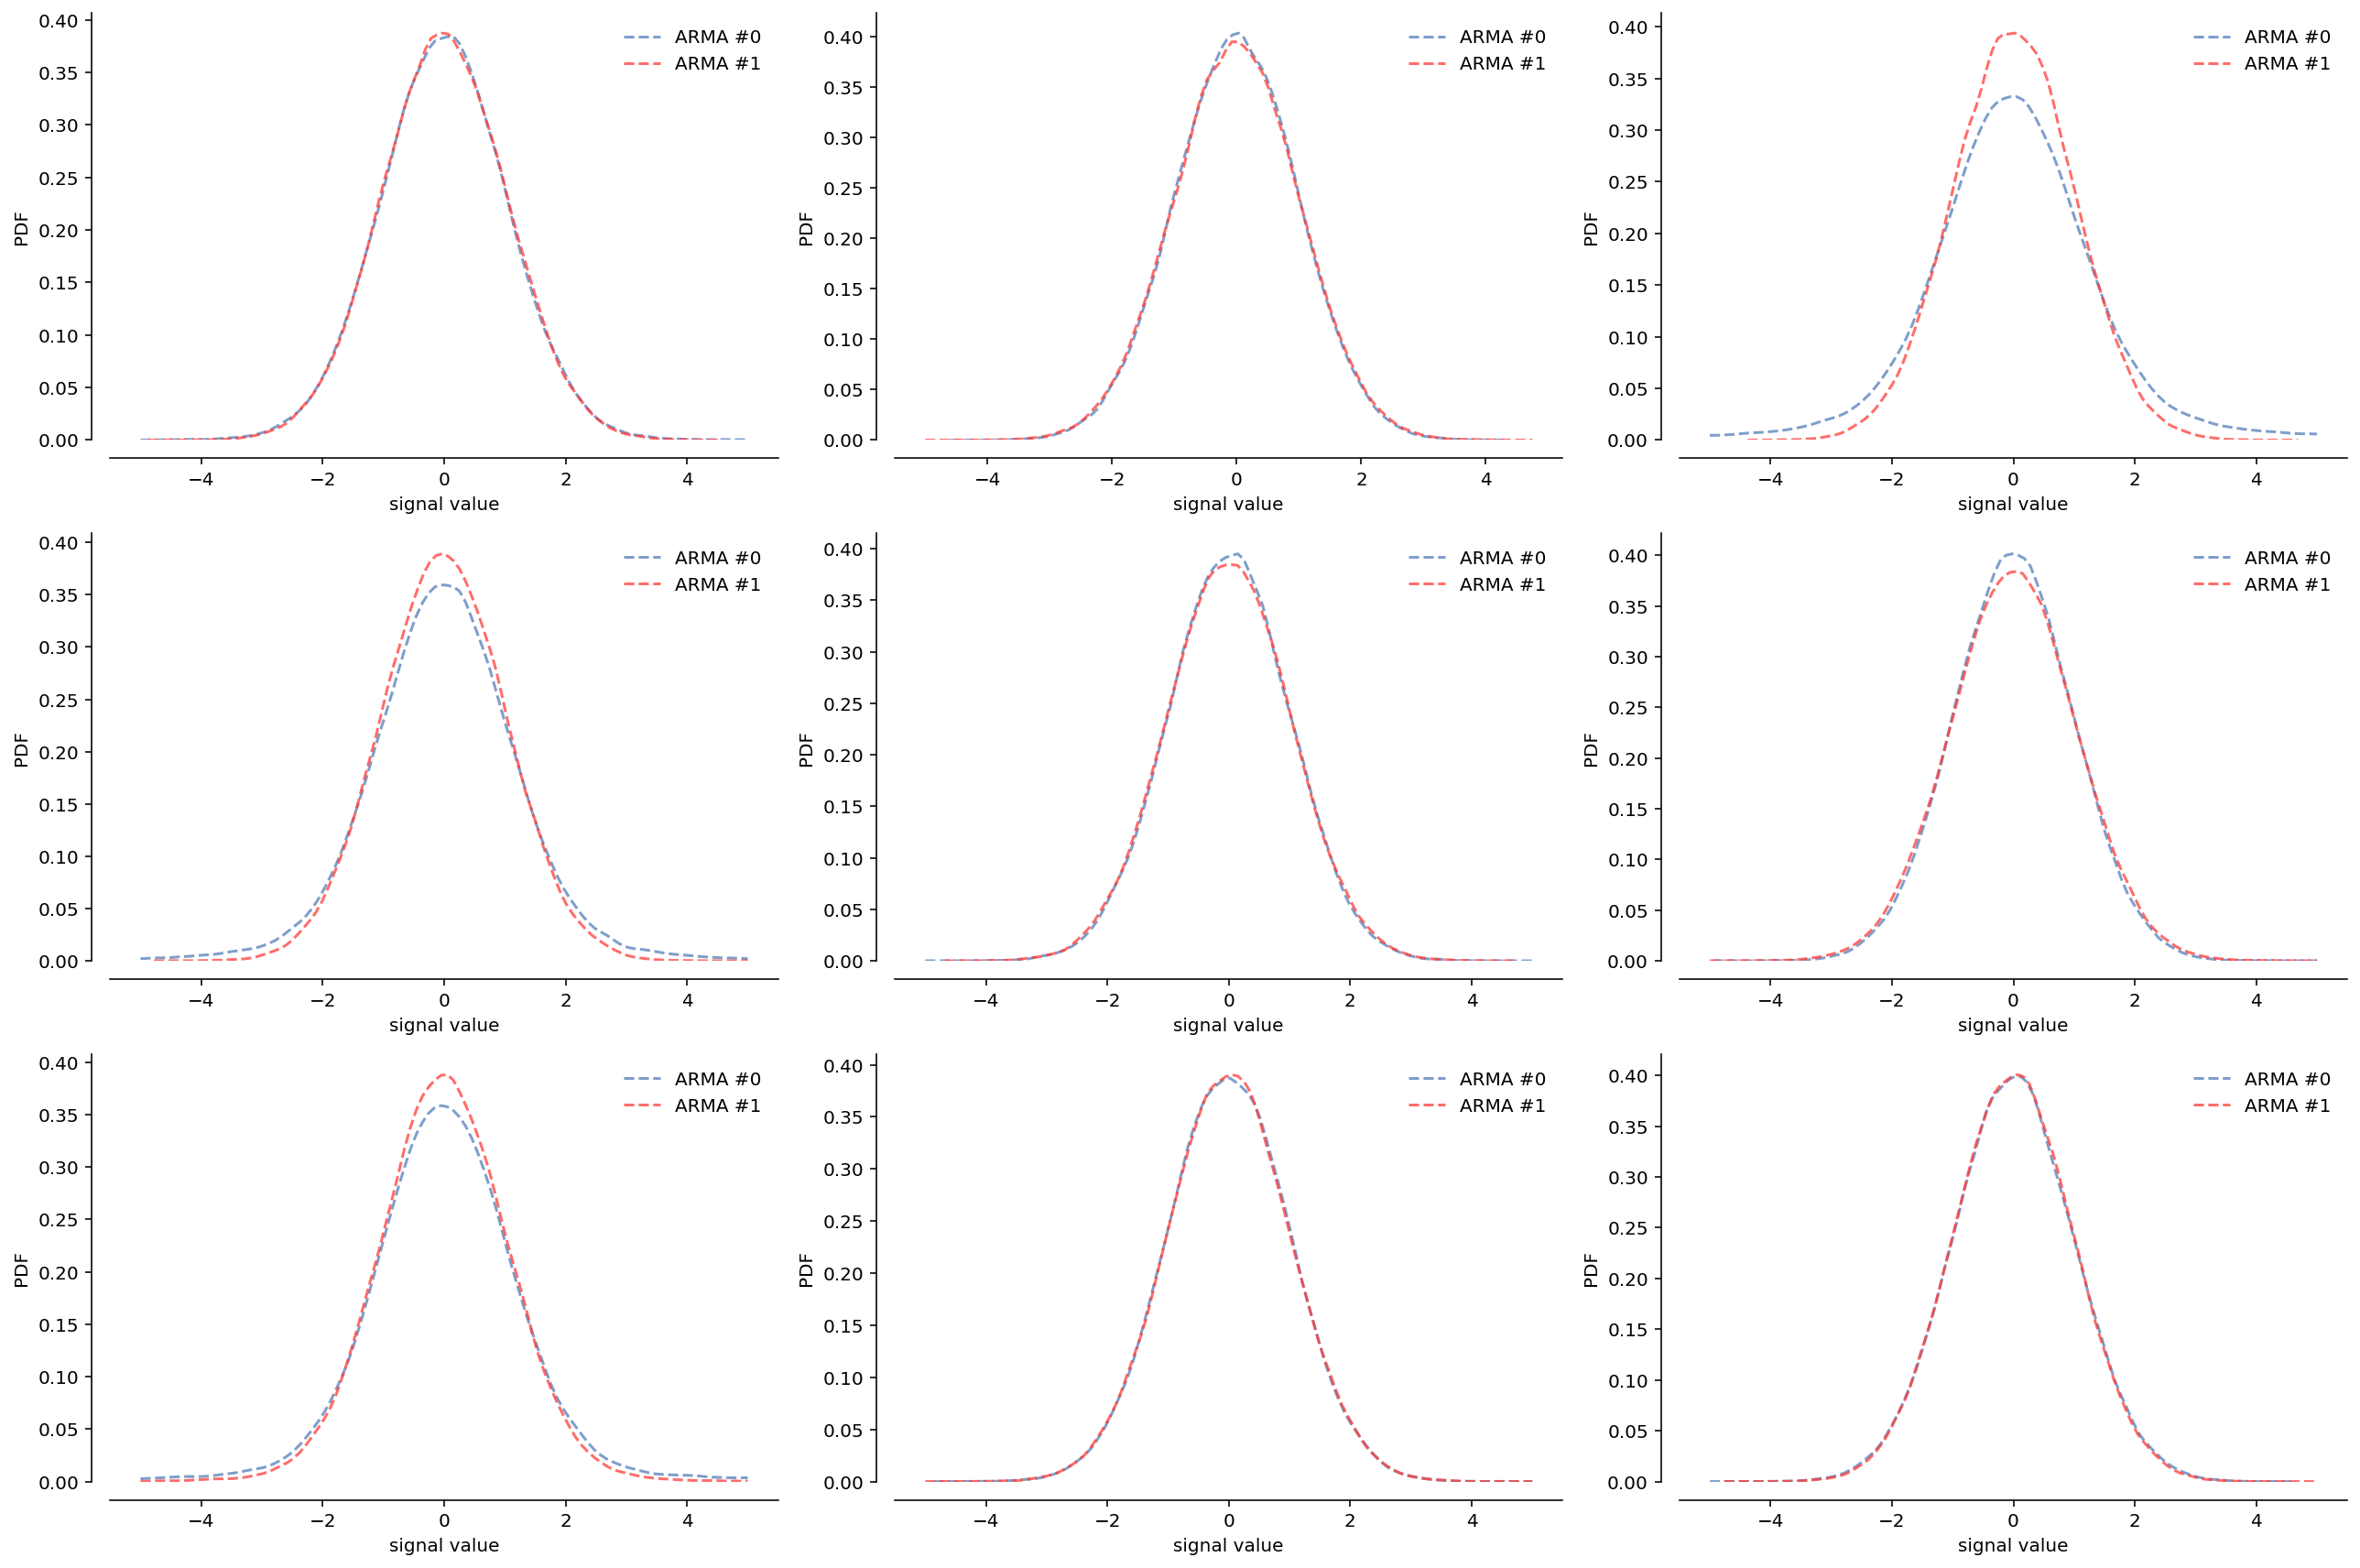

In [4]:
with FigureManager(3, 3) as (_, axs):
    for i, ax in enumerate(axs.flat):
        crt_data = two_armas.dataset[i]
        for k in range(len(two_armas.orders)):
            crt_mask = crt_data.usage_seq == k
            crt_sig = crt_data.y[crt_mask]
            print(f"ARMA {i}.{k} std = {np.std(crt_sig):.2f}")
            sns.kdeplot(
                crt_sig, alpha=0.75, ls="--", label=f"ARMA #{k}", clip=(-5, 5), ax=ax
            )

        ax.set_xlabel("signal value")
        ax.set_ylabel("PDF")

        ax.legend(frameon=False)

In [5]:
t0 = time.time()
two_armas.result = hyper_score_ar(
    lambda *args, **kwargs: BioWTARegressor(
        *args,
        **kwargs,
        weights=[
            make_random_arma(3, 0, rng=kwargs["rng"]).a
            for _ in range(two_armas.n_models)
        ],
    ),
    two_armas.dataset,
    two_armas.metric,
    n_models=two_armas.n_models,
    n_features=two_armas.n_features,
    rate_weights=two_armas.rate,
#     trans_mat=1 - 1 / 20,
    progress=tqdm,
    progress_trial=tqdm,
    monitor=["r", "weights_", "prediction_"],
)
t1 = time.time()
print(
    f"Median accuracy score: {two_armas.result[0]:.2}. (Took {t1 - t0:.2f} seconds.)"
)



Median accuracy score: 0.69. (Took 186.82 seconds.)


In [6]:
two_armas.rolling_score = []
for i in tqdm(range(two_armas.n_signals)):
    crt_dataset = two_armas.dataset[i]
    crt_r = two_armas.result[1].history[i].r
    crt_inferred = np.argmax(crt_r, axis=1)

    crt_loc, crt_sliding_score = calculate_sliding_score(
        two_armas.metric, crt_dataset.usage_seq, crt_inferred
    )
    two_armas.rolling_score.append((crt_loc, crt_sliding_score))

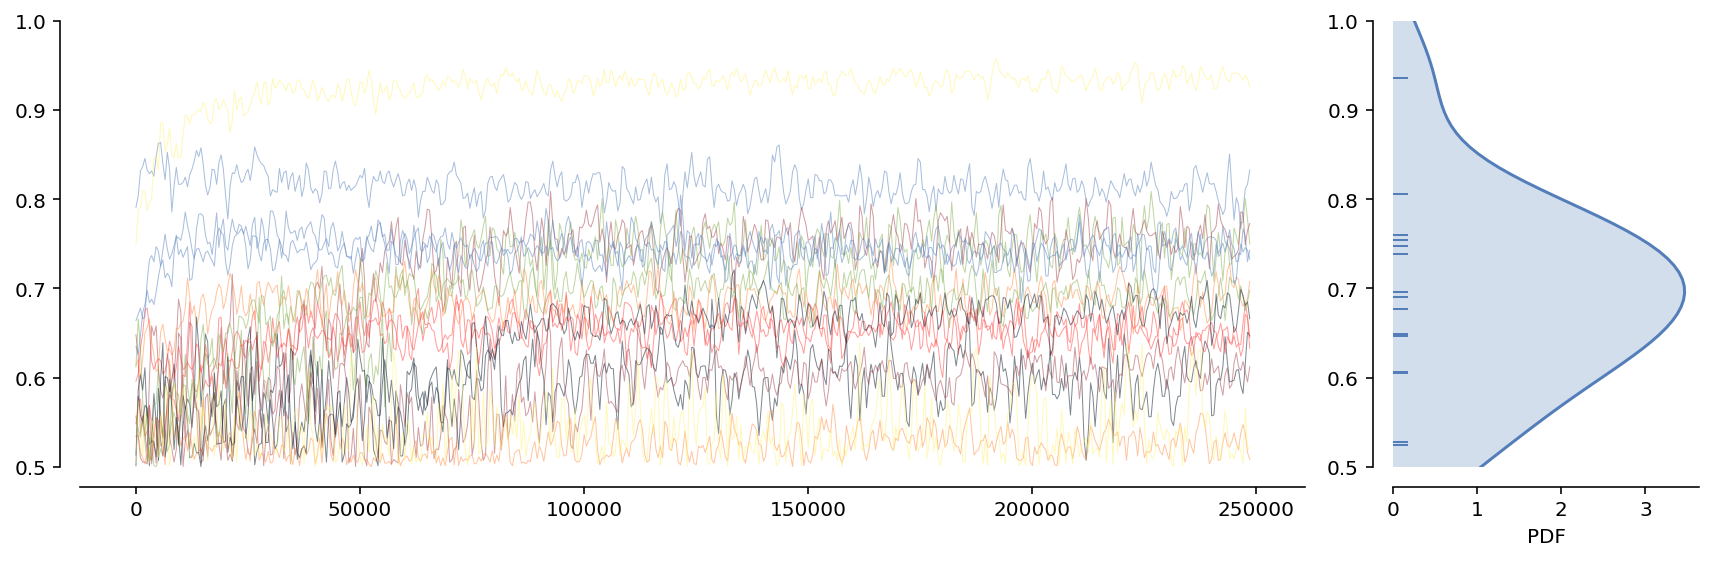

In [7]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": [4, 1]}, sharey=True) as (
    _,
    (ax1, ax2),
):
    for i in range(two_armas.n_signals):
        ax1.plot(*two_armas.rolling_score[i], lw=0.5, alpha=0.5, label=f"sig #{i}")

    ax1.set_ylim(0.5, 1.0)

    late_scores = [np.mean(_[1][-20:]) for _ in two_armas.rolling_score]
    sns.distplot(
        late_scores,
        kde_kws={"shade": True},
        hist=False,
        rug=True,
        vertical=True,
        ax=ax2,
    )
    ax2.set_xlabel("PDF")
    ax2.tick_params(axis="y", labelleft=True)

In [8]:
two_armas.late_acc = []
two_armas.expected_acc = []
two_armas.expected_approx_acc = []
for i, crt_dataset in enumerate(tqdm(two_armas.dataset)):
    crt_true = crt_dataset.usage_seq
    crt_pred = np.argmax(two_armas.result[1].history[i].r, axis=1)
    crt_n = len(crt_pred) // 2
    crt_late_acc = unordered_accuracy_score(crt_true[-crt_n:], crt_pred[-crt_n:])
    two_armas.late_acc.append(crt_late_acc)

    crt_armas = two_armas.dataset.armas[i]
    crt_delta = crt_armas[1].a - crt_armas[0].a

    crt_x = to_hankel(crt_dataset.y, two_armas.n_features)[
        two_armas.n_features - 1 : -1
    ]
    crt_s = np.dot(crt_delta, crt_x[-crt_n:].T)
    crt_pcorrect = 0.5 * (1 + erf(np.abs(crt_s) / np.sqrt(8)))
    two_armas.expected_acc.append(np.mean(crt_pcorrect))

    crt_approx_std_s = np.std(crt_dataset.y[-crt_n:]) * np.sqrt(np.sum(crt_delta ** 2))
    crt_approx_mean_abs_s = crt_approx_std_s * np.sqrt(2 / np.pi)
    crt_approx_mean_pcorrect = 0.5 * (
        1 + erf(np.abs(crt_approx_mean_abs_s) / np.sqrt(8))
    )
    two_armas.expected_approx_acc.append(crt_approx_mean_pcorrect)

two_armas.late_acc = np.asarray(two_armas.late_acc)
two_armas.expected_acc = np.asarray(two_armas.expected_acc)
two_armas.expected_approx_acc = np.asarray(two_armas.expected_approx_acc)

The "approximate" expected accuracy score is an attempt to estimate the clustering performance while ignoring the correlations between different components of the lag vector. It doesn't work very well.

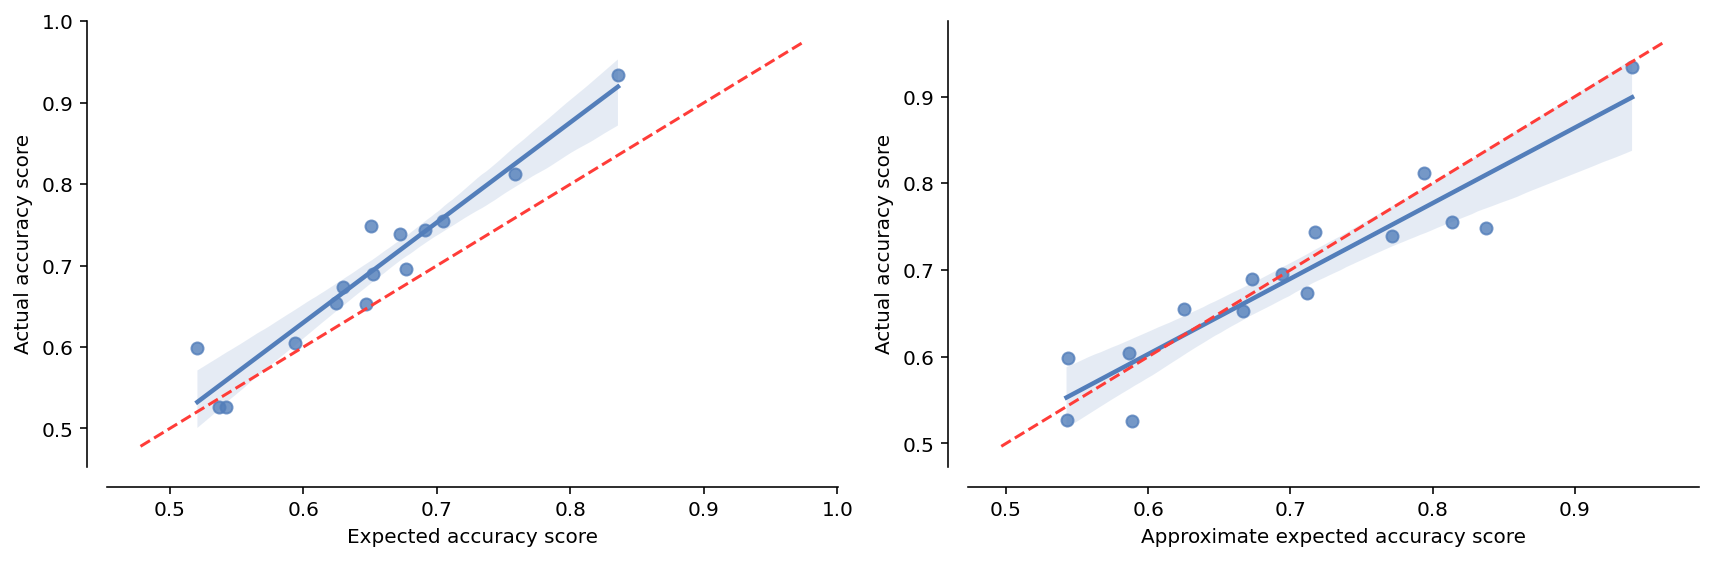

In [9]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    sns.regplot(two_armas.expected_acc, two_armas.late_acc, ax=ax1)
    crt_low = min(ax1.get_xlim()[0], ax1.get_ylim()[0])
    crt_high = max(ax1.get_xlim()[1], ax1.get_ylim()[1])
    ax1.plot([crt_low, crt_high], [crt_low, crt_high], "--")
    ax1.set_xlabel("Expected accuracy score")
    ax1.set_ylabel("Actual accuracy score")
    
    sns.regplot(two_armas.expected_approx_acc, two_armas.late_acc, ax=ax2)
    crt_low = min(ax2.get_xlim()[0], ax2.get_ylim()[0])
    crt_high = max(ax2.get_xlim()[1], ax2.get_ylim()[1])
    ax2.plot([crt_low, crt_high], [crt_low, crt_high], "--")
    ax2.set_xlabel("Approximate expected accuracy score")
    ax2.set_ylabel("Actual accuracy score")

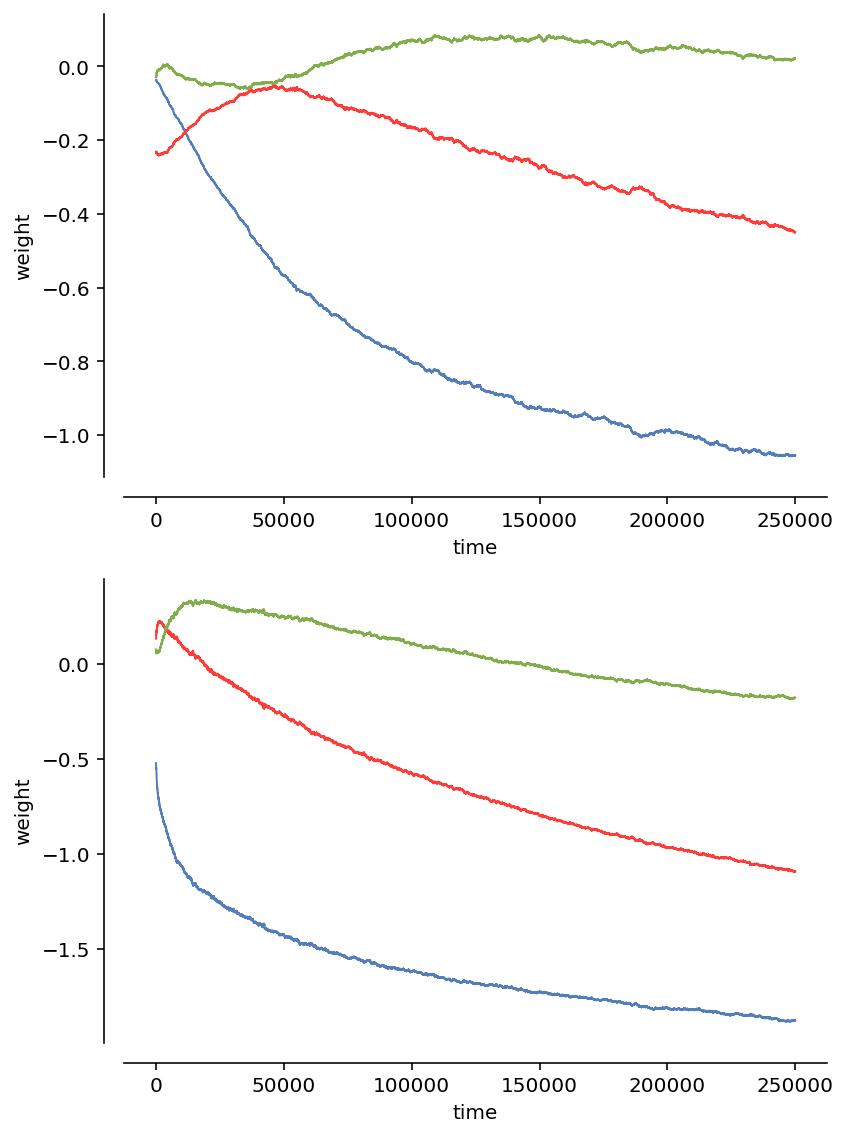

In [10]:
with FigureManager(2, 1) as (_, (ax1, ax2)):
    crt_history = two_armas.result[1].history[5]
    crt_range = slice(0, 500_000)
    ax1.plot(
        np.arange(len(crt_history.weights_))[crt_range],
        crt_history.weights_[crt_range, 0, :],
        lw=1.0,
        # c="black",
    )
    ax2.plot(
        np.arange(len(crt_history.weights_))[crt_range],
        crt_history.weights_[crt_range, 1, :],
        lw=1.0,
        # c="black",
    )

    ax1.set_xlabel("time")
    ax1.set_ylabel("weight")
    
    ax2.set_xlabel("time")
    ax2.set_ylabel("weight")

## Test save to file

This uses results from above.

In [11]:
with h5py.File(os.path.join("temp", "test_complex_write.hdf5"), "w") as f:
    write_object_hierarchy(f, two_armas)

In [12]:
with h5py.File(os.path.join("temp", "test_complex_write.hdf5"), "r") as f:
    two_armas_loaded = read_namespace_hierarchy(f)

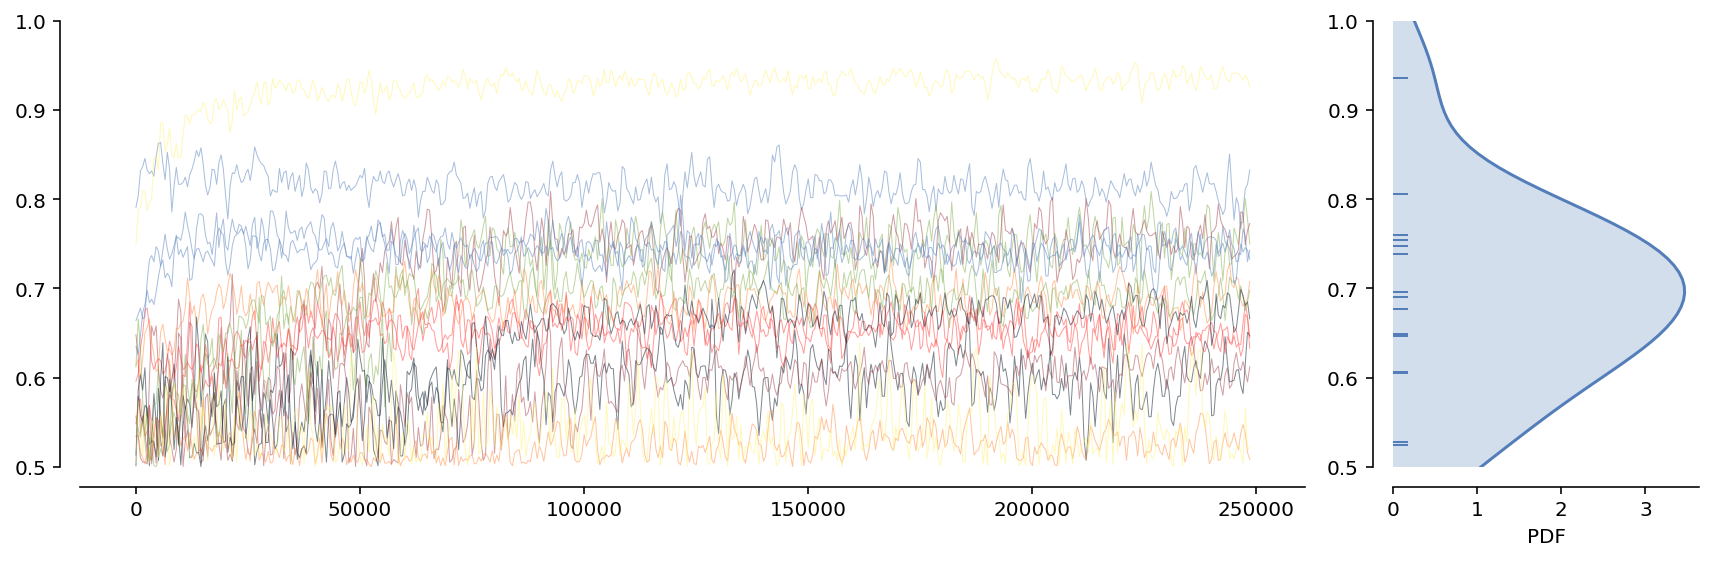

In [13]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": [4, 1]}, sharey=True) as (
    _,
    (ax1, ax2),
):
    for i in range(two_armas_loaded.n_signals):
        ax1.plot(*two_armas_loaded.rolling_score[i], lw=0.5, alpha=0.5, label=f"sig #{i}")

    ax1.set_ylim(0.5, 1.0)

    late_scores = [np.mean(_[1][-20:]) for _ in two_armas_loaded.rolling_score]
    sns.distplot(
        late_scores,
        kde_kws={"shade": True},
        hist=False,
        rug=True,
        vertical=True,
        ax=ax2,
    )
    ax2.set_xlabel("PDF")
    ax2.tick_params(axis="y", labelleft=True)